# Customer Churn Explainability Notebook

This notebook provides **global and local explanations** of the XGBoost churn model using **SHAP values**.  

- **Global feature importance:** Understand which features drive churn across all customers.  
- **Customer-level explanations:** Inspect individual churn probabilities and feature contributions.  
- **Risk segmentation:** Identify high-risk customers and prioritize retention actions.  
- **Business insights:** Translate model insights into actionable strategies.  

> Note: This notebook assumes the **trained XGBoost pipeline** (preprocessing + model) is already available.

In [1]:
# imports
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load trained pipeline and data 
model = joblib.load("../models/churn_model_final_v1.joblib")
df = pd.read_csv("../data/processed/clean_customer_churn.csv")

In [2]:
# Split features and target 
X = df.drop(columns=["Churn","customerID"])   # drop target & ID to get features
y = df["Churn"]       # select target column

# Split dataset into train and test sets (80%/20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42          
)

# convert target from Yes/No to 0/1 for modeling
y_train = y_train.map({"No":0,"Yes":1})
y_test  = y_test.map({"No":0,"Yes":1})

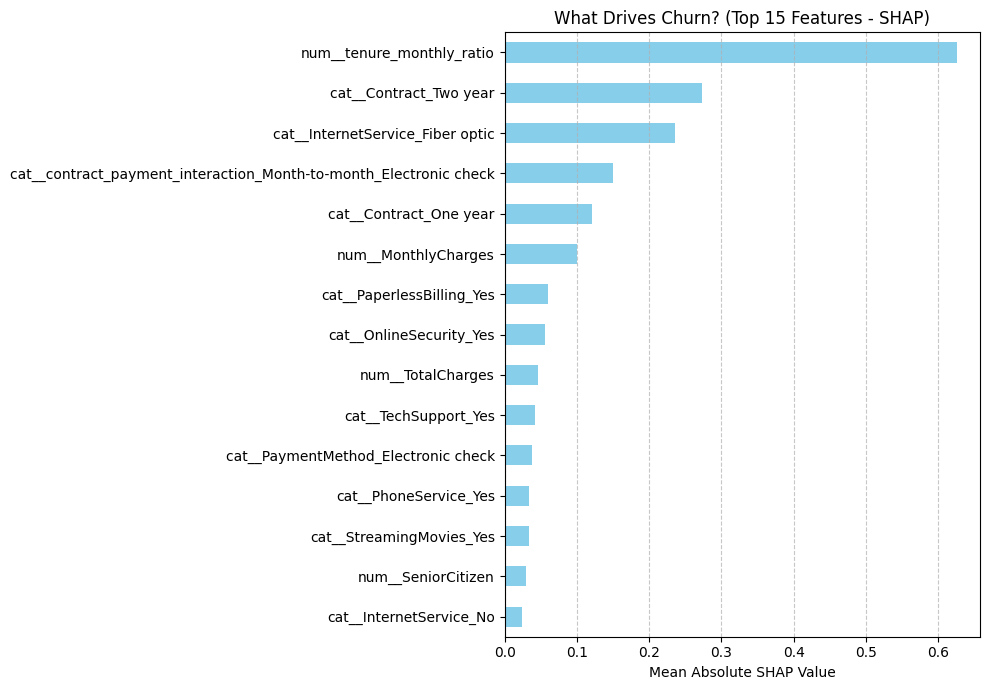

In [3]:
# --- SHAP values extraction ---
from explainability import get_shap_values 

# transform test data, create explainer, and get SHAP values
X_test_transformed, explainer, shap_values, preprocessor = get_shap_values(model, X_test)

# Global feature importance
from explainability import plot_shap_global    

# get feature names from preprocessing
feature_names = preprocessor.get_feature_names_out()

# plot top 15 features by mean absolute SHAP value
plot_shap_global(
    shap_values, 
    feature_names, 
    top_n=15, 
    title="What Drives Churn? (Top 15 Features - SHAP)"
)

### Feature Importance (Top 15)

- **Tenure-to-Monthly Ratio** is the strongest churn predictor.  
- **Contract Type**: Long-term contracts (Two-year, One-year) strongly affect churn.  
- **Service Tech**: Fiber optic internet ranks among top-3 drivers.  
- **Payment & Billing**: Month-to-month + electronic check increases churn risk.  
- **Financials**: Monthly & total charges have moderate impact.  

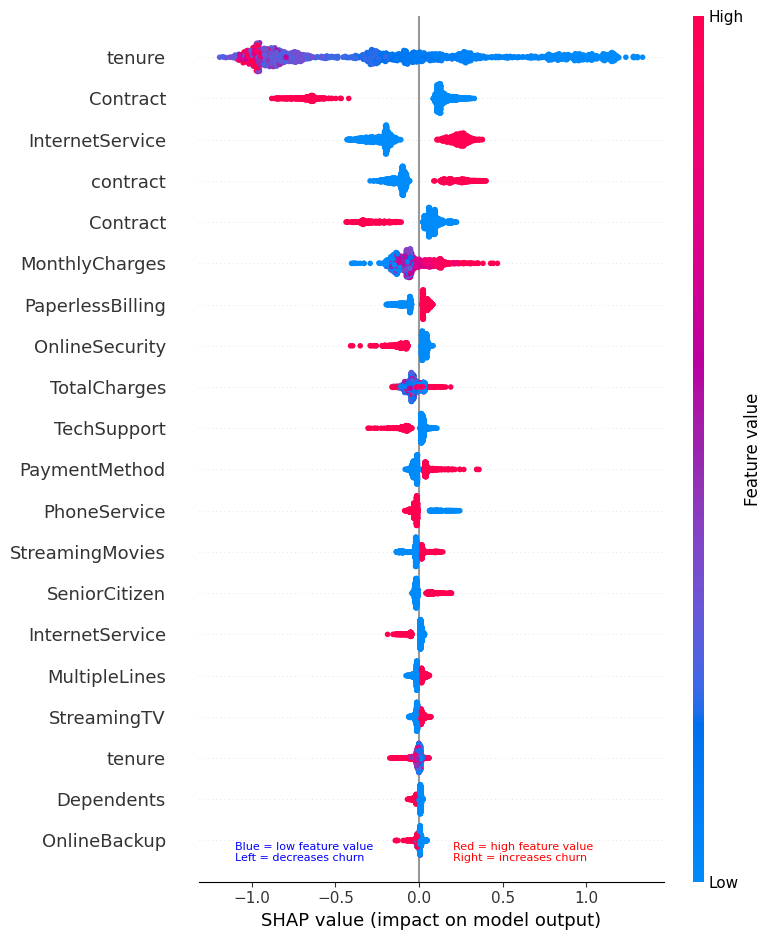

In [4]:
# --- SHAP summary plot ---
from explainability import plot_shap_summary    

# map one-hot encoded features back to original column names for readability
original_feature_map = [
    col.split('_')[0] if hasattr(transformer,'get_feature_names_out') else col
    for name, transformer, cols in preprocessor.transformers_
    for col in (transformer.get_feature_names_out(cols) if hasattr(transformer,'get_feature_names_out') else cols)
]

# create SHAP summary plot using mapped feature names
plot_shap_summary(
    shap_values, 
    X_test_transformed, 
    original_feature_map
)

### SHAP Summary Insights

- **Tenure**: Longer tenure (blue) reduces churn risk.  
- **Contract Type**: Long-term contracts (red) stabilize churn probability.  
- **Internet Service**: Certain tiers (red) increase churn likelihood.  
- **Monthly Charges**: Higher costs (red) raise churn probability.  
- **Support Services**: Online Security & Tech Support (red) lower churn.  
- **Billing & Payment**: Paperless billing and payment methods moderately affect churn.  
- **Total Charges**: High total charges slightly reduce churn risk.  
- **Minor Drivers**: Dependents & Online Backup have minimal influence.

Churn probability for customer 1: 29.75%


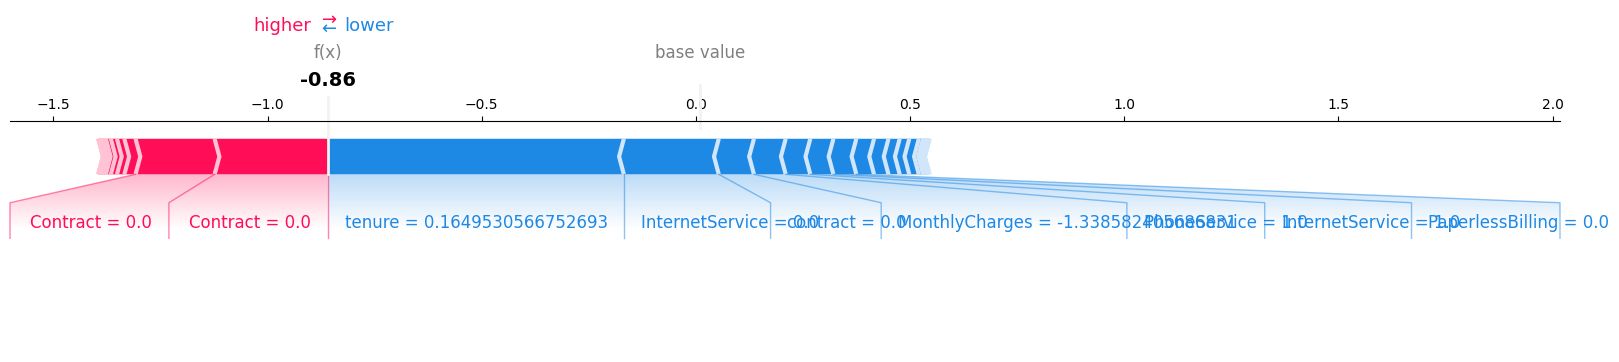

In [5]:
# --- Single customer explainability --- 
from explainability import explain_single_customer

# explain first customer (i=1)
explain_single_customer(model, X_test_transformed, shap_values, explainer, original_feature_map, i=1)

### Single-Customer SHAP Insights

- **Prediction**: f(x) = -0.86 → low churn probability.  
- **Retention Drivers (Blue)**: Long tenure, low MonthlyCharges strongly reduce risk.  
- **Risk Factors (Red)**: Certain contract features increase risk, but are outweighed.  
- **Dominant Features**: Tenure and MonthlyCharges are the strongest contributors.  
- **Outcome**: Overall model predicts the customer is likely to stay.

In [6]:
from explainability import get_high_risk_customers

# get top high-risk customers
high_risk_customers = get_high_risk_customers(model, X_test, threshold=0.5)
high_risk_customers.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,tenure_monthly_ratio,services_count,contract_payment_interaction,Churn_Probability
2572,Female,0,No,No,1,Yes,Yes,Fiber optic,No,No,...,Yes,Month-to-month,Yes,Electronic check,94.60,94.60,0.010571,3,Month-to-month_Electronic check,0.883267
1971,Male,1,No,No,1,Yes,Yes,Fiber optic,No,No,...,Yes,Month-to-month,Yes,Electronic check,93.55,93.55,0.010689,3,Month-to-month_Electronic check,0.882926
1595,Male,1,No,No,1,Yes,Yes,Fiber optic,No,No,...,No,Month-to-month,Yes,Electronic check,88.80,88.80,0.011261,3,Month-to-month_Electronic check,0.882546
5774,Female,1,No,No,1,Yes,No,Fiber optic,No,No,...,Yes,Month-to-month,Yes,Electronic check,89.30,89.30,0.011198,3,Month-to-month_Electronic check,0.876839
6738,Female,1,No,No,1,Yes,No,Fiber optic,No,No,...,Yes,Month-to-month,Yes,Electronic check,85.00,85.00,0.011765,3,Month-to-month_Electronic check,0.876610


Customer 2572 Churn Probability = 0.883


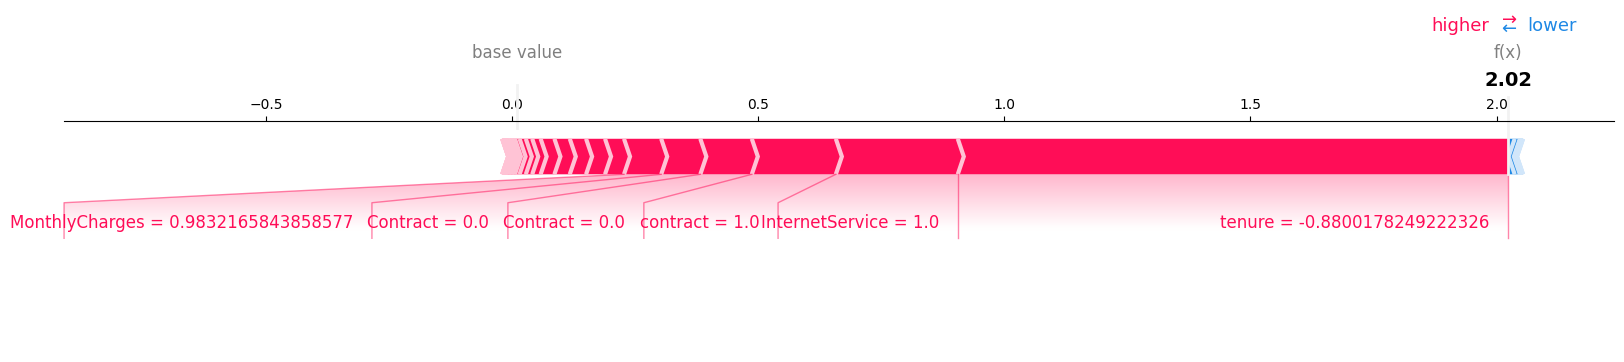

In [7]:
from explainability import explain_top_n_customers

# Force plot for top high-risk customer
explain_top_n_customers(high_risk_customers, X_test, X_test_transformed, shap_values, explainer, original_feature_map, top_n=1)

### High-Risk Customer SHAP Summary

- **Prediction**: f(x) = 2.02 → very high churn probability.  
- **Main Risk Drivers (Red)**: New customer (low tenure), high MonthlyCharges, month-to-month contract.  
- **Service Influence**: Fiber internet and lack of support services increase churn likelihood.  
- **Outcome**: Strong red forces dominate, indicating urgent retention attention needed.

**Note:** The top high-risk customers have very similar churn probabilities. Showing all plots for the top churners adds little extra insight, as the key drivers are almost identical. Focus on aggregated risk or the top 1 customer for clarity. 
If you wish to display top N churners, you just have to change the top_n argument.

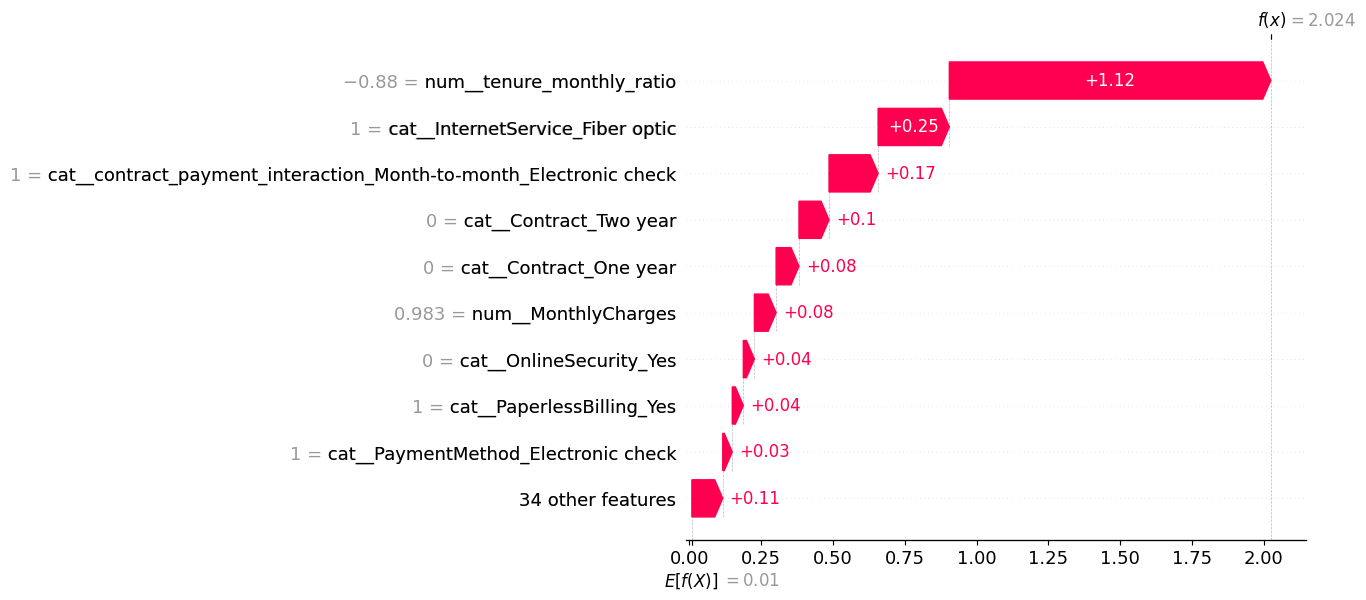

In [11]:
# --- Waterfall plot for top customer ---
from explainability import plot_shap_waterfall
plot_shap_waterfall(explainer, shap_values, X_test_transformed, preprocessor,
                    high_risk_customers=high_risk_customers, X_test=X_test, top_n=1)

## 🔴 High-Risk Summary

- **Primary Driver:** Low `tenure_monthly_ratio` adds **+1.12** SHAP impact (strongest churn signal).  
- **Additional Risk:** Fiber optic service (**+0.25**) and electronic check payments (**+0.17**) increase churn risk.  

Risk_Bucket
Low Risk       548
Medium Risk    607
High Risk      252
dtype: int64


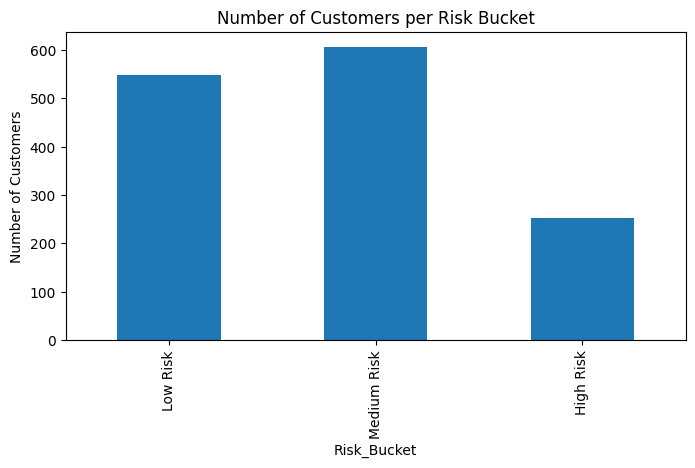

In [9]:
# --- Risk segmentation ---
from explainability import compute_risk_buckets
test_results = X_test.copy()
f_x_test = explainer.expected_value + shap_values.sum(axis=1)
test_results["Churn_Probability"] = 1/(1+np.exp(-f_x_test))

# Compute buckets
test_results["Risk_Bucket"] = compute_risk_buckets(test_results["Churn_Probability"])
risk_summary = test_results.groupby("Risk_Bucket").size().reindex(["Low Risk","Medium Risk","High Risk"])
print(risk_summary)

# Plot risk distribution
risk_summary.plot(kind='bar', figsize=(8,4), title="Number of Customers per Risk Bucket")
plt.ylabel("Number of Customers")
plt.show()

### Customer Risk Segmentation Summary

- **Volume**: Most customers are Low or Medium Risk.  
- **Medium Risk**: Largest segment (~600 customers), key retention focus.  
- **High Risk**: ~250 customers require immediate action.  
- **Balanced Segmentation**: Model effectively separates population by churn risk.  
- **Key Drivers**: Tenure and Contract type boost retention; high MonthlyCharges and Month-to-month contracts increase churn risk.  
- **Actionable Insight**: Prioritize retention efforts on High Risk segment.

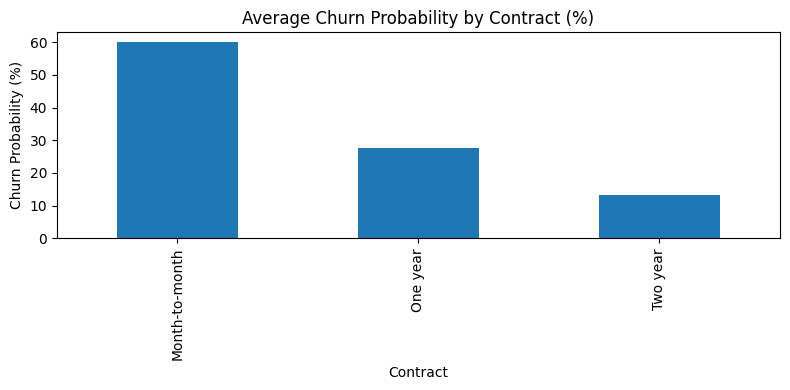

In [10]:
# --- Cohort analysis ---
cohort_feature = "Contract"
if cohort_feature in test_results.columns:
    cohort_summary = (test_results.groupby(cohort_feature)["Churn_Probability"]
                      .mean().sort_values(ascending=False)*100)
    cohort_summary.plot(kind="bar", figsize=(8,4), title=f"Average Churn Probability by {cohort_feature} (%)")
    plt.ylabel("Churn Probability (%)")
    plt.tight_layout()
    plt.show()

### Contract Type Risk Analysis

- **Contract Churn Trends**: Month-to-month contracts → ~60% churn; One/Two-year → ~28% / 13%.  
- **Retention Strategy**: Focus on converting High Risk and month-to-month users to long-term contracts.  
- **Key SHAP Insight**: Tenure and Contract type are the strongest churn inhibitors; Month-to-month contracts are the main risk driver.

### Business Recommendations

- **High-Risk Retention**: Proactively target the ~250 High Risk customers with personalized retention offers (discounts, loyalty perks, tailored services).  
- **Contract Strategy**: Encourage month-to-month customers to switch to One-year or Two-year contracts to reduce churn probability.  
- **Monitor Key Drivers**: Regularly track tenure, monthly charges, and contract type; these are the top factors influencing churn.  
- **Financial Incentives**: Offer incentives to customers with high MonthlyCharges or low tenure-to-charge ratios to improve loyalty.  
- **Service Enhancements**: Promote protective services like OnlineSecurity and TechSupport, which reduce churn risk.  
- **Payment & Billing Guidance**: Encourage preferred payment methods and paperless billing where they help retention.  
- **Data-Driven Personalization**: Leverage SHAP explanations to provide individualized recommendations for each high-risk customer.  
- **Cohort Monitoring**: Track churn trends by contract type and service tier to adjust marketing and retention campaigns dynamically.  
- **Priority Focus**: Convert month-to-month high-risk users first, then focus on Medium Risk customers to prevent escalation.  
- **Continuous Model Feedback**: Re-run explainability analysis periodically to identify emerging churn drivers and update retention strategies.